In [181]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [182]:
import numpy as np
import math
from skimage import io, util
import cv2
import heapq
from collections import defaultdict
import matplotlib.pyplot as plt
import os

In [183]:
class Graph: 
  
    def __init__(self,graph): 
        self.graph = graph 
        self.org_graph = [i[:] for i in graph] 
        self.ROW = len(graph) 
        self.COL = len(graph[0])
  
    '''While there is a path from the source to the sink,
    returns true
    '''
    def breadth_first_search(self, s, t, parent):
  
        #List that stores whether a node has been visited or not
        visited = [False]*(self.ROW)
  
        queue=[] #Queue to stores the nodes that are to be traversed 

        queue.append(s) #The source node is appended to the queue

        visited[s] = True
  
        #Traversing while the queue still has nodes to be traversed
        while len(queue) > 0:

            u = queue.pop(0) #Current node u is the next node from the queue

            #For all the other nodes in the graph
            for ind, v in enumerate(self.graph[u]): 
                if visited[ind] == False and v > 0:
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If the sink was visited, then we return True and look for another traversal
        if visited[t]:
            return True
        else:
            return False
          
    # Function for Depth first search 
    # Traversal of the graph
    def dfs(self, graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                self.dfs(graph,i,visited)
  
    # Returns the min-cut of the given graph 
    def ford_fulkerson(self, source, sink):

        s = 0
        
        parent = [-1]*(self.ROW) #Tracking the parent of each node
        
        max_flow = 0 # Initialize a variable to store the max flow of the graph, initially 0
    
        # Augment the flow while there is path from source to sink 
        while self.breadth_first_search(source, sink, parent) : 
  
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while not s == source: 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow += path_flow 
  
            # Set the desination node to the sink
            v = sink 
            while not v == source: #While v is not 0
                u = parent[v] # u is the parent node for v
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                v = parent[v] #Creates a backwards edge
  
        visited=len(self.graph)*[False]
        self.dfs(self.graph,s,visited)
                    
        return visited

In [184]:
imgs = []

def normaliseImage(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm

#Compute the error surface between the newly chosen block and the old blocks at the overlap region
def overlapDiff(patch, patch_length, overlap_region, result, y, x): 
    error = 0

    if x > 0:
        left = patch[:, :overlap_region] - result[y:y+patch_length, x:x+overlap_region]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap_region, :] - result[y:y+overlap_region, x:x+patch_length]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap_region, :overlap_region] - result[y:y+overlap_region, x:x+overlap_region]
        error -= np.sum(corner**2)

    return error
 

def random_patch(texture, patch_length):
    np.random.seed(1111)
    h, w, _ = texture.shape
    i = np.random.randint(h - patch_length)
    j = np.random.randint(w - patch_length)

    return texture[i:i+patch_length, j:j+patch_length]


def bestPatch(texture, patch_length, overlap_region, result, y, x):
    height, width, _ = texture.shape
    errors = np.zeros((height - patch_length, width - patch_length))

    for h in range(height - patch_length):
        for w in range(width - patch_length):
            patch = texture[h:h+patch_length, w:w+patch_length]
            err = overlapDiff(patch, patch_length, overlap_region, result, y, x)
            errors[h, w] = err

    h, w = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[h:h+patch_length, w:w+patch_length]

def texture_synthesis(texture, patch_length, patches_num, mode="cut", seq=False):

    patches_high, patches_wide = patches_num

    overlap_region = patch_length // 6
    
    count = 0

    h = (patches_high * patch_length) - (patches_high - 1) * overlap_region
    w = (patches_wide * patch_length) - (patches_wide - 1) * overlap_region

    texture = normaliseImage(texture)

    result = np.zeros((h, w, texture.shape[2]))

    for h in range(patches_high):
        for w in range(patches_wide):
            count += 1
            j = h * (patch_length - overlap_region)
            i = w * (patch_length - overlap_region)

            if mode == "random" or h == 0 and w == 0:
                patch = random_patch(texture, patch_length)
            elif mode == "cut": # default mode
                patch = bestPatch(texture, patch_length, overlap_region, result, j, i)
                patch = minCutPatch(patch, patch_length, overlap_region, result, j, i)
                
            result[j:j+patch_length, i:i+patch_length] = patch
            
            if seq:
                io.imshow(result)
                io.show()
      
    return result


In [185]:
def minCutPatch(patch, patchLength, overlap, res, y, x):
    
    patch = patch.copy()
    y_dim, x_dim, _ = patch.shape
    min_Cut = np.zeros_like(patch, dtype=bool)
    
    #for x values > 0
    if x > 0:
        left_side = patch[:, :overlap] - res[y:y+y_dim, x:x+overlap]
        patch_1 = patch[:, :overlap]
        patch_2 = res[y:y+y_dim, x:x+overlap]

        leftL2 = np.sum(left_side**2, axis=2)
        
        
        overlapped_parts_graph = graph_min_cut(patch_1, patch_2)
        
        visited_parts = minimum_graph_cut(overlapped_parts_graph)
        
        result = get_res_patch(visited_parts, patch_1, patch_2,res)

        for i in range(patch_1.shape[0]):
            for j in range(patch_1.shape[1]):
                patch[i][j] = result[i][j]
    
    #for y values greater than 0
    if y > 0:
        top_side = patch[:overlap, :] - res[y:y+overlap, x:x+x_dim]
        patch_1 = patch[:overlap, :]
        patch_2 = res[y:y+overlap, x:x+x_dim]
        
        patch_1 = cv2.rotate(patch_1, cv2.cv2.ROTATE_90_CLOCKWISE)
        patch_2 = cv2.rotate(patch_2, cv2.cv2.ROTATE_90_CLOCKWISE)
        
        upL2 = np.sum(top_side**2, axis=2)
        
        overlapped_parts_graph = graph_min_cut(patch_1, patch_2)
        
        visited_parts = minimum_graph_cut(overlapped_parts_graph)
    
        result = get_res_patch(visited_parts, patch_1, patch_2,res)
        
        result = cv2.rotate(result, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        for i in range(patch_1.shape[1]):
            for j in range(patch_1.shape[0]):
                patch[i][j] = result[i][j]

    return patch

In [186]:
def get_res_patch(visited, patch_1, patch_2,res):
    node_map = {}

    res_patch = np.zeros(shape=(patch_1.shape[0],patch_1.shape[1],3))
    count = 1
    for row in range(len(patch_1[0])):
        for col in range(len(patch_1)):
            node_map[count] = (col,row)
            count += 1
            
    region = np.zeros_like(res_patch)
    
#     print(res_patch.shape,patch_2.shape)
    
    for i in range(1,len(visited)-1):
        row = node_map[i][0]
        col = node_map[i][1]
        
        if visited[i]:
            res_patch[row][col] = np.array(patch_1[row][col])
            region[row][col] = np.array([255.0,0.0,0.0])
#             print("1",row,col,patch_1[row][col],res_patch[row][col])
        else:
            res_patch[row][col] = np.array(patch_2[row][col])
#             print("2",row,col,patch_2[row][col],res_patch[row][col])
            region[row][col] = np.array([0.0,0.0,255.0])

    imgs.append(region)
            
    return res_patch

In [187]:
def graph_min_cut(patch_1, patch_2):
    
    nodes = patch_1.shape[0] * patch_2.shape[1] + 2
    
    graph_min = [[0]*(nodes) for row in range(nodes)]
    
    map_of_nodes = {}
    
    count = 1
    
    for row in range(len(patch_1[0])):
        for col in range(len(patch_1)):
            map_of_nodes[count] = (col,row)
            count += 1
    
    #decrementing count
    count -= 1
    
    twenty = 20
    
    for row in range(0,nodes):
        for col in range(0,nodes):
            if (row == 0 and 1<=col<=len(patch_1)) or (col == nodes-1 and count-len(patch_1)<=row<=count):
                graph_min[row][col] = float('inf')
            elif row != 0:
                if (row + twenty) < nodes-2:
                    if (col == row+twenty):
                        prd,pcd = map_of_nodes[row+twenty]
                        prs,pcs = map_of_nodes[row]
                        weight = np.sum(np.square(patch_1[prs][pcs] - patch_2[prs][pcs]) + np.square(patch_1[prd][pcd] - patch_2[prd][pcd]))
                        norm = np.sum(np.square(patch_1[prs][pcs] - patch_1[prd][pcd]) + np.square(patch_2[prs][pcs] - patch_2[prd][pcd]),)
                        graph_min[row][row+twenty] = weight/(norm+1e-10)
                if ((row + 1) < (nodes-2)) and (col == (row + 1)):
                    if (col % len(patch_1)) != 1:
                        prs,pcs = map_of_nodes[row]
                        prd,pcd = map_of_nodes[row+1]
                        weight = np.sum(np.square(patch_1[prs][pcs] - patch_2[prs][pcs]) + np.square(patch_1[prd][pcd] - patch_2[prd][pcd]))
                        norm = np.sum(np.square(patch_1[prs][pcs] - patch_1[prd][pcd]) + np.square(patch_2[prs][pcs] - patch_2[prd][pcd]))
                        x = norm+(1e-10)
                        graph_min[row][row+1] = weight/x

    return graph_min

In [188]:
def minimum_graph_cut(overlappedgraph):
    gr = Graph(overlappedgraph)
  
    #set source
    source = 0
    #set sink
    sink = len(overlappedgraph)
    sink = sink - 1

    #perform min cut
    vii = gr.ford_fulkerson(source, sink)
    
    return vii

(64, 64, 4)


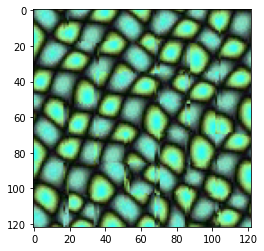

In [201]:
texture = io.imread("img/test.png")
# texture = io.imread("img/test2.png")
# io.show()
print(texture.shape)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

#default mode cut
# plt.imshow(texture_synthesis(texture, 20, (3, 3)))
plt.imshow(texture_synthesis(texture, 20, (7, 7)))

io.show()

In [192]:
# for i,img in enumerate(imgs):
#     plt.figure()
#     plt.imshow(img)